# Final Challenge - Walkthrough - DataFrame

**You are required to turn in this completed notebook and a Python's script that runs on the Hadoop cluster.** This notebook is only for developing and testing your code.

We still use the [Safegraph data](https://www.safegraph.com/covid-19-data-consortium) to better understand how NYC response to the COVID-19 pandemic. If you have any doubts about the data, please consult SafeGraph's documentation for [Places Schema](https://docs.safegraph.com/v4.0/docs/places-schema) and [Weekly Pattern](https://docs.safegraph.com/v4.0/docs/weekly-patterns).

## Problem Description

To assess the food access problem in NYC before and during the COVID-19 pandemic, we would like to plot the visit patterns for all food stores (including restaurants, groceries, deli's, etc.) such as the one shown below.

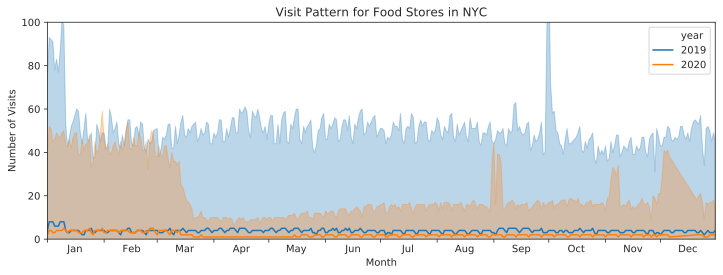

In [ ]:
#@title A visualization of Visit Pattern for all food stores in NYC
#@markdown The solid lines show the median patterns and the transparent areas show the standard deviation across stores for 2019 and 2020.

However, we suspect that the visit patterns may vary across different type of stores. Our hypothesis is that we have changed our shopping behavior during the pandemic. For example, we visit Fast Food and Whole Saler restaurants more often comparing to full service restaurants and typical supermarkets. In particular, we are interested in the following store categories with their **NAICS** codes:

* *Big Box Grocers*: `452210` and `452311`
* *Convenience Stores*: `445120`
* *Drinking Places*: `722410`
* *Full-Service Restaurants*: `722511`
* *Limited-Service Restaurants*: `722513`
* *Pharmacies and Drug Stores*: `446110` and `446191`
* *Snack and Bakeries*: `311811` and `722515`
* *Specialty Food Stores*: `445210`, `445220`, `445230`, `445291`, `445292`, and `445299`
* *Supermarkets (except Convenience Stores)*: `445110`

In [ ]:
#@markdown The plot above was created by the `linePlot()` function (defined later), which takes a Panda's DataFrame consisting of 5 columns as follows.

,year,date,median,low,high
0,2019,2020-01-01,14,0,74
1,2019,2020-01-02,26,0,89
2,2019,2020-01-03,28,0,97
3,2019,2020-01-04,32,0,107
4,2019,2020-01-05,20,0,79


* `year`: column is used for showing the trend line category (orange or blue).
* `date`: denotes the day of the year for each data point, for which we project to to year 2020. We chose 2020 as the base year because it is a leap year and would have all possile dates (i.e. month + day combination). The actual date for the data point would be month and day from `date` combined with the year in `year`.
* `median`: is used to draw the solid line describing the median visit counts across all stores for that date.
* `low`: the lower bound of the "confidence interval". In our plot, it is the `median` minus the standard deviation but will be kept at 0 or above.
* `high`: the higher bound of the "confidence interval". In our plot, it is the `median` plus the standard deviation but will be kept at 0 or above.

**NOTES**
* `low` and `high` value will be used to create the transparent area that we see in the plot.
* `low`, `median`, `high` should be computed not only for stores that had visits but also for all stores in `Core Places` that fit the category. As we learned previously, restaurants with no visits will not be reported in the `Weekly Pattern` data set.

## Objective
Your task is to produce the visit pattern data for each of the store category above so that we can plot them in a similar way to our first plot for compare and contrast. You must process the 2 year worth of pattern data on the cluster, and produce 9 CSV-formated folders (header must be included), one for each category. Your code will be evaluated using 50 cores (5 executors and 10 cores per executor).

####**RUN COMMAND**
```
PYTHON_VERSION=3 spark-submit --num-executors 10 --executor-cores 5 BDM_HW4_LastName.py OUTPUT_PREFIX
```
where `OUTPUT_PREFIX` is a user-supplied argument to specify where to your code should create 9 sub-folders for the output.

####**INPUT DATA (on HDFS)**
You will need the Places as well as the Weekly Pattern data set for this homework. Both have been filtered to the NYC area, and are available on HDFS under the folder `/data/share/bdm/`:
```
hdfs:///data/share/bdm/core-places-nyc.csv
hdfs:///data/share/bdm/weekly-patterns-nyc-2019-2020/*
```

####**OUTPUT DATA (on HDFS)**

Your code must create the following 9 sub-folders (corresponding to 9 categories) under the `OUTPUT_PREFIX` provided in the command line argument:

* `big_box_grocers`
* `convenience_stores`
* `drinking_places`
* `full_service_restaurants`
* `limited_service_restaurants`
* `pharmacies_and_drug_stores`
* `snack_and_bakeries`
* `specialty_food_stores`
* `supermarkets_except_convenience_stores`

Each folder contains the CSV records for each category with the same schema specified above, **sorted by `year` and `date`**. For example, if I run your code with the following command.

```
PYTHON_VERSION=3 spark-submit --num-executors 10 --executor-cores 5 BDM_HW4_LastName.py test
```

I should have the following 9 folders populated with the expected output:
```
test/big_box_grocers
test/convenience_stores
test/drinking_places
test/full_service_restaurants
test/limited_service_restaurants
test/pharmacies_and_drug_stores
test/snack_and_bakeries
test/specialty_food_stores
test/supermarkets_except_convenience_stores
```

In addition, when I run the following command:
```
hadoop fs -getmerge test/big_box_grocers big_box_grocers.csv
hadoop fs -getmerge test/convenience_stores convenience_stores.csv
...
```

I should get 9 CSV files ready to run with the `linePlot()` defined below. A sample output `fast_food_chains.csv` is provided for your reference. This is the visit pattern for all fast food chains (restaurants associated with a brand) in NYC.

####**TIME LIMITATION: 2 minute**
Using 50 cores (the command line specified above), your code must take **less than 2 minute** to complete.

## Approach

At a high level, we will do the following to tackle the problem:

1.   Sample input data
2.   Develop our pipeline (in this notebook)
3.   Convert to a Spark stand-alone script
4.   Run our code on cluster and extract data
5.   Validate on this notebook



## TASK 1 - SAMPLE INPUT DATA

We would like to take advantage of the interactivity of a notebook to develop our Spark's pipeline. Ideally, we would like to have both data sets available on Colab for developoment. However, the pattern data set is considerably large (8GB), and would be expensive (in term of computing resources) to upload and work with them from here. So our strategy is to *sample* the pattern data set to only 1% (~80MB). We will use the POI data set as is.

The simple code below can be used for sampling 1% of the pattern data. We make use of [RDD's sample() method](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.sample.html#pyspark.RDD.sample) for this task. The first argument (`False`) is to specify that we would like to do a sample without replacement. Note that we separate the header and union it with the sampled data set to retained the header after sampling.

```python
from pyspark import SparkContext
import itertools

if __name__=='__main__':
    sc = SparkContext()
    rdd = sc.textFile('/data/share/bdm/weekly-patterns-nyc-2019-2020/*')
    header = rdd.first()
    rdd.sample(False, 0.01) \
        .coalesce(1) \
        .mapPartitions(lambda x: itertools.chain([header], x)) \
        .saveAsTextFile('weekly-patterns-nyc-2019-2020-sample')
```

### A. [TODO] Run the above script on our cluster
Please save the above code snippet into a Python file, then choose a method of your choice (e.g. GitHub, HUE, or using `scp`) to transfer this script onto your storage on the cluster.

Assuming that you have named the script as `hw4_sample.py`, then once on the cluster, run the script with the following command:

```
PYTHON_VERSION=3 spark-submit --num-executors 10 --executor-cores 5 hw4_sample.py
```

After running the script, there should be a new folder created on your home folder on HDFS: `weekly-patterns-nyc-2019-2020-sample`. There should only be a file in that folder. That should be our sampled CSV file.


NOTE: a few common errors that you might be running into:
- If you had run the above command before, you have to remove the existing output folder by running the following command:
> `hadoop fs -rm -r -skipTrash weekly-patterns-nyc-2019-2020-sample`
- Remember to do `kinit` if your submission requires authentication.



### B. [TODO] Download data sets to the notebook
Download the file from Step A and upload to your Google Drive. Make sure to enable the share option of "Any with link" to the file, and copy its ID in the shared link. Run the below command to have the `weekly-patterns-nyc-2019-2020-sample.csv` file available to our notebook. Remember to replace ID with your file id. You can double check if the file is right by using the Files tab on the left.

Please do the same for the core places data set. Since the file is not too large, you can simply download this file from HUE.

In [ ]:
!gdown --id 1E_8-BRiGLKPpC-YEJASWSg2dtgjAaCEq -O weekly-patterns-nyc-2019-2020-sample.csv
!gdown --id 1rYpqt3e216KpE81P4xrUE8v59A2bUG48 -O core-places-nyc.csv

Downloading...
From: https://drive.google.com/uc?id=1E_8-BRiGLKPpC-YEJASWSg2dtgjAaCEq
To: /content/weekly-patterns-nyc-2019-2020-sample.csv
100% 87.4M/87.4M [00:00<00:00, 153MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rYpqt3e216KpE81P4xrUE8v59A2bUG48
To: /content/core-places-nyc.csv
100% 31.6M/31.6M [00:00<00:00, 146MB/s]


## TASK 2 - DEVELOP THE PIPELINE USING SPARK DATAFRAME

In [ ]:
!pip install pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T

sc = SparkContext()
spark = SparkSession(sc)

     |████████████████████████████████| 281.3 MB 34 kB/s 
     |████████████████████████████████| 198 kB 46.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=65c8d0a4a19461a7096ee27097e7d369bbb1d6b0b7db76a4faa8c788faf63d8a
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [ ]:
import datetime
import json
import numpy as np

dfPlaces = spark.read.csv('core-places-nyc.csv', header=True, escape='"')
dfPattern = spark.read.csv('weekly-patterns-nyc-2019-2020-sample.csv', header=True, escape='"')

### C. [TODO] NAICS code lookup
From the list of NAICS codes, we need to define a look-up table (e.g. a dictionary) that allows us to map from an NAICS code into a category. We should number the categories from 0 to 8 as follows:

0. *Big Box Grocers*: `452210` and `452311`
1. *Convenience Stores*: `445120`
2. *Drinking Places*: `722410`
3. *Full-Service Restaurants*: `722511`
4. *Limited-Service Restaurants*: `722513`
5. *Pharmacies and Drug Stores*: `446110` and `446191`
6. *Snack and Bakeries*: `311811` and `722515`
7. *Specialty Food Stores*: `445210`, `445220`, `445230`, `445291`, `445292`, and `445299`
8. *Supermarkets (except Convenience Stores)*: `445110`

We need to define 2 variables:

* `CAT_CODES`: a set of all NAICS codes of interest (`452210`, `452311`, ...)
* `CAT_GROUP`: a dictionary map from a cat code (e.g. `722513`) to a group number (e.g. `4`)

In [ ]:
CAT_CODES = {'445210', '722515', '445299', '445120', '452210', '311811', '722410', '722511', '445220', '445292', '445110', '445291', '445230', '446191', '446110', '722513', '452311'}
CAT_GROUP = {'452311': 0, '452210': 0, '445120': 1, '722410': 2, '722511': 3, '722513': 4, '446191': 5, '446110': 5, '722515': 6, '311811': 6, '445299': 7, '445220': 7, '445292': 7, '445291': 7, '445230': 7, '445210': 7, '445110': 8}
print('CAT_CODES', CAT_CODES)
print('CAT_GROUP', CAT_GROUP)

CAT_CODES {'311811', '445292', '445110', '445230', '445291', '445120', '722511', '445299', '722513', '452210', '452311', '446191', '445220', '722410', '445210', '446110', '722515'}
CAT_GROUP {'452311': 0, '452210': 0, '445120': 1, '722410': 2, '722511': 3, '722513': 4, '446191': 5, '446110': 5, '722515': 6, '311811': 6, '445299': 7, '445220': 7, '445292': 7, '445291': 7, '445230': 7, '445210': 7, '445110': 8}


### D. [TODO] Extract places of interest
Since we are only interested in stores with the above NAICS code, we need to filter the Core Places data set to extract the store IDs of interest. Here, we will read in the `core-poi-nyc.csv`, only keep those with the `naics_code` value to be within the `CAT_CODES` set. Then, we will extract only two columns `placekey` and `naics_code` for output. Note that, we're going to use `placekey` instead `safegraph_place_id` as the unique identifier for each store.


In [ ]:
dfD = dfPlaces.filter(dfPlaces['naics_code'].isin(CAT_CODES))\
              .select('placekey', 'naics_code')

dfD.show(5)

+-------------------+----------+
|           placekey|naics_code|
+-------------------+----------+
|22d-223@627-wfy-yvz|    722410|
|22g-222@627-wbn-dvz|    722410|
|22p-222@627-wc7-yd9|    722511|
|23g-222@627-wc8-7h5|    722515|
|22x-222@627-wc2-mhq|    722513|
+-------------------+----------+
only showing top 5 rows



### E. [TODO] Map from NAICS codes to groups
Next, we will create a new column `group` that maps the NAICS codes to our defined group using `CAT_GROUP`. This column will be of type Integer. For this step, we are going to need a UDF function to do so.

In [ ]:
udfToGroup = F.udf(lambda x: CAT_GROUP[x], T.IntegerType())

dfE = dfD.withColumn('group', udfToGroup('naics_code'))
dfE.show(5)

+-------------------+----------+-----+
|           placekey|naics_code|group|
+-------------------+----------+-----+
|22d-223@627-wfy-yvz|    722410|    2|
|22g-222@627-wbn-dvz|    722410|    2|
|22p-222@627-wc7-yd9|    722511|    3|
|23g-222@627-wc8-7h5|    722515|    6|
|22x-222@627-wc2-mhq|    722513|    4|
+-------------------+----------+-----+
only showing top 5 rows



### F. Cache the places DataFrame
Here, we will drop the `naics_code` column from Step E and cache this result DataFrame since it will be used multiple times (in Step F and when joining with the pattern data set).

In [ ]:
dfF = dfE.drop('naics_code').cache()
dfF.show(5)

+-------------------+-----+
|           placekey|group|
+-------------------+-----+
|22d-223@627-wfy-yvz|    2|
|22g-222@627-wbn-dvz|    2|
|22p-222@627-wc7-yd9|    3|
|23g-222@627-wc8-7h5|    6|
|22x-222@627-wc2-mhq|    4|
+-------------------+-----+
only showing top 5 rows



### G. [TODO] Compute the number of stores per group
As specified in the problem description, we are going to compute statistics (median, high, and low) with respect the total number of stores in each category (i.e. not only those with non-zero visits). So we need to know beforehand the number of stores in each category. In this step, we will construct a dictionary, called `groupCount`, that maps from a group number (0 to 8) to the number of stores in that group. This should be computed from `dfF`.

In [ ]:
groupCount = dict(dfF\
                .groupBy('group').count().collect())
groupCount

{0: 177, 1: 814, 2: 2423, 3: 10627, 4: 3699, 5: 2513, 6: 4522, 7: 658, 8: 2225}

### H. [TODO] Filter the Pattern data and explode the visits by day
With the list of stores of interest in `dfF`, we can filter our pattern data with `dfF` based on `placekey` value. We then also perform an explosion of `visits_by_day` into `year`, `date`, and `count` based on `date_range_start`. This can be achieved in a similar way that we did in HW3. Note that the `date` column will only consits of the month and day value in the form of `MM-DD` since the year value is already on its own column.


In [ ]:
def expandVisits(date_range_start, visits_by_day):
    visit = json.loads(visits_by_day)
    date = datetime.datetime.strptime(date_range_start[:10], '%Y-%m-%d')
    for i in visit:
      if date.year in [2019,2020]:
        yield (date.year, date.strftime('%m-%d-%Y')[:5], i)
      date+= datetime.timedelta(days=1)

visitType = T.StructType([T.StructField('year', T.IntegerType()),
                          T.StructField('date', T.StringType()),
                          T.StructField('visits', T.IntegerType())])

udfExpand = F.udf(expandVisits, T.ArrayType(visitType))

dfH = dfPattern.join(dfF, 'placekey') \
    .withColumn('expanded', F.explode(udfExpand('date_range_start', 'visits_by_day'))) \
    .select('group', 'expanded.*')
dfH.show(5)

+-----+----+-----+------+
|group|year| date|visits|
+-----+----+-----+------+
|    5|2019|01-01|     8|
|    5|2019|01-02|    10|
|    5|2019|01-03|    14|
|    5|2019|01-04|    12|
|    5|2019|01-05|    10|
+-----+----+-----+------+
only showing top 5 rows



### I. [TODO] Compute daily stats for each group
Next, we need to compute the daily statistics for each group. This requires us to group our data by `group` and by `year` + `date`. Similar to Homework 3, we will collect the list of all visits for each group and day and perform statistics on top of it. Remember to use `groupCount` to know exactly how many stores for each group.

It is expected to see many median values as 0 because we do not have all the stores in the pattern data sets, so when computing the median, most of them would turn into 0s.

In [ ]:
# Remember to use groupCount to know how long the visits list should be
def computeStats(group, visits):
    diff = groupCount[group]-len(visits)
    std = np.std(diff*[0]+visits)
    med = np.median(diff*[0]+visits)
    low = max(0, med-std)
    high = max(0, med+std)
    return (int(med), int(low), int(high))

statsType = T.StructType([T.StructField('median', T.IntegerType()),
                          T.StructField('low', T.IntegerType()),
                          T.StructField('high', T.IntegerType())])

udfComputeStats = F.udf(computeStats, statsType)

dfI = dfH.groupBy('group', 'year', 'date') \
    .agg(F.collect_list('visits').alias('visits')) \
    .withColumn('stats', udfComputeStats('group', 'visits'))

dfI.show(5)

+-----+----+-----+------------+---------+
|group|year| date|      visits|    stats|
+-----+----+-----+------------+---------+
|    0|2019|01-01| [6, 10, 12]|{0, 0, 1}|
|    0|2019|01-02| [8, 60, 20]|{0, 0, 4}|
|    0|2019|01-03|[8, 108, 26]|{0, 0, 8}|
|    0|2019|01-04|[12, 96, 28]|{0, 0, 7}|
|    0|2019|01-05| [0, 44, 24]|{0, 0, 3}|
+-----+----+-----+------------+---------+
only showing top 5 rows



### J. [TODO] Prepare data for output

Before we can output each data group, we need to do perform the following processing:

* We must expand the `stats` column into `median`, `low`, and `high` as instructed using the same approach in Step H (`.*` operator). 

* We need to sort the data again by `group`, `year` and `date`.

* We need to prefix the `date` column with `'2020-'`.

Note that we are going to cache this DataFrame because we would need to iterate through them for each output category in the next step.

In [ ]:
dfJ = dfI\
    .select('group', 'year','date', 'stats.*')\
    .orderBy('group', 'year','date')\
    .withColumn('date', F.concat(F.lit('2020-'), F.col('date')))\
    .cache()

dfJ.show(5)

+-----+----+----------+------+---+----+
|group|year|      date|median|low|high|
+-----+----+----------+------+---+----+
|    0|2019|2020-01-01|     0|  0|   1|
|    0|2019|2020-01-02|     0|  0|   4|
|    0|2019|2020-01-03|     0|  0|   8|
|    0|2019|2020-01-04|     0|  0|   7|
|    0|2019|2020-01-05|     0|  0|   3|
+-----+----+----------+------+---+----+
only showing top 5 rows



### K. Writing data output
We are going to output the data for each group. The idea is to filter the groups one by one, then drop the `group` column before writing in the CSV format. Since when instructed to write out with headers, Spark's DataFrame will write the header row for *each* partition. So we'll have to `coalesce()` our data into a single partition before writing to get only 1 header row.

In this step, let's filter and write out only the first group (group 0, *Big Box Grocers*).

In [ ]:
OUTPUT_PREFIX = '/content'
filename = 'big_box_grocers'
dfJ.filter(dfJ.group == 0) \
    .drop('group') \
    .coalesce(1) \
    .write.csv(f'{OUTPUT_PREFIX}/{filename}',
               mode='overwrite', header=True)

!ls -1 /content/big_box_grocers/part-*
!head  /content/big_box_grocers/part-*

/content/big_box_grocers/part-00000-be174c13-715b-40ec-9dc0-0ac8c762e155-c000.csv
year,date,median,low,high
2019,2020-01-01,0,0,1
2019,2020-01-02,0,0,4
2019,2020-01-03,0,0,8
2019,2020-01-04,0,0,7
2019,2020-01-05,0,0,3
2019,2020-01-06,0,0,3
2019,2020-01-21,0,0,0
2019,2020-01-22,0,0,0
2019,2020-01-23,0,0,1


### L. [TODO] Writing data output for all groups
Complete a code that repeats Step K for all 9 categories, and write to 9 folders under `/content` (our output prefix). After this step, when listing the folder `/content`, we should see all 9 folders.

In [ ]:
OUTPUT_PREFIX = '/content'

outputs = ['big_box_grocers',
'convenience_stores',
'drinking_places',
'full_service_restaurants',
'limited_service_restaurants',
'pharmacies_and_drug_stores',
'snack_and_bakeries',
'specialty_food_stores',
'supermarkets_except_convenience_stores']

for i, filename in enumerate(outputs):
  dfJ.filter(f'group={i}')\
    .drop('group') \
    .coalesce(1) \
    .write.csv(f'{OUTPUT_PREFIX}/{filename}',
               mode='overwrite', header=True)

!ls /content/ | grep -Ev ".csv|sample_data"

big_box_grocers
convenience_stores
drinking_places
full_service_restaurants
limited_service_restaurants
pharmacies_and_drug_stores
snack_and_bakeries
specialty_food_stores
supermarkets_except_convenience_stores


## TASK 3 - CONVERT TO A SPARK STAND-ALONE SCRIPT
Follow the instructions on our W7 lectures, we can convert the code in our notebook to a .py file using the below structure. Remember to fill `TO_BE_COMPLETED` with all of the previous steps.


```python
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
import datetime
import json
import numpy as np
import sys

def main(sc, spark):
    '''
    Transfer our code from the notebook here, however, remember to replace
    the file paths with the ones provided in the problem description.
    '''
    dfPlaces = spark.read.csv('/data/share/bdm/core-places-nyc.csv', header=True, escape='"')
    dfPattern = spark.read.csv('/data/share/bdm/weekly-patterns-nyc-2019-2020/*', header=True, escape='"')
    OUTPUT_PREFIX = sys.argv[1]
    TO_BE_COMPLETED

if __name__=='__main__':
    sc = SparkContext()
    spark = SparkSession(sc)
    main(sc, spark)
```

Save the above file as `BDM_HW4_df.py`, and use your preferred method (e.g. GitHub, HUE, or `scp`) to upload the script onto cluster.

## TASK 4 - RUN OUR SCRIPT ON CLUSTER

Run the `hw4_df.py` script using the provided command:
```
PYSPARK_VERSION=3 spark-submit --num-executors 5 --executor-cores 10 BDM_HW4_df.py hw4_output
```

Make sure to create the folder `hw4_output` (output prefix) beforehand by using HUE (selecting New > Folder) or by running the following hadoop command:
```
hadoop fs -mkdir hw4_output
```

The above job should take minutes to complete. We can inspect the output afterwards. Data can be gathered by one of the two methods:

1. Download directly from HUE and upload to Google Drive, similar to TASK 1.
2. Run a series of `-getmerge` commands to retrieve all files to cluster, and then upload them to GitHub.
> ```
hadoop fs -getmerge hw4_output/big_box_grocers/* big_box_grocers.csv
...
```

## TASK 5 - VALIDATE FILE ON THE NOTEBOOK

After having our outputs on Google Drive and/or GitHub. We can fetch them here similar to TASK 1, or use `git clone` to clone them to the notebook. Then use the Line Plot below to validate.

### Line Plot
Below is the code snippet for `linePlot()` which can be used to validate your results. The function takes a CSV filename, a plot title, and the limit for the Y axis as inputs, and output a line plot. Your input CSV file must have the exact schema specified above, or it will return an error. For example, here we are showing the line plot for all fast food chains in NYC.

In [ ]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
import IPython
%matplotlib inline
IPython.display.set_matplotlib_formats('svg')
pd.plotting.register_matplotlib_converters()

In [ ]:
def linePlot(filename, title=None, ylim=None):
    df = pd.read_csv(filename, parse_dates=['date'])
    years = df['year'].unique()
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.set_style("ticks")
    sns.lineplot(x='date', y='median', hue='year', data=df, 
                 palette=sns.color_palette(n_colors=len(years)), ci=None)
    for year in years:
        ydf = df[df['year']==year]
        plt.fill_between(x=ydf['date'], y1=ydf['low'], y2=ydf['high'],
                         alpha=0.3, edgecolor='face')

    ax.set_xlim([datetime.date(2020, 1, 1), datetime.date(2020, 12, 31)])
    ax.set_ylim(top=ylim if ylim else df['high'].max(), bottom=0)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=16))
    ax.xaxis.set_major_formatter(mticker.NullFormatter())
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
    for tick in ax.xaxis.get_minor_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Visits')
    if title:
        ax.set_title(title)

### Expected Output

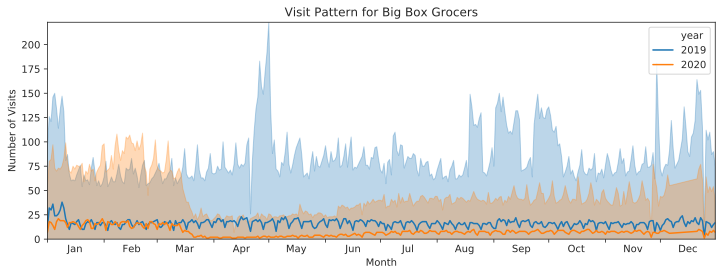

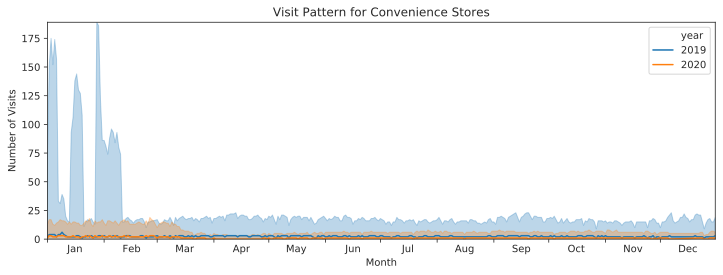

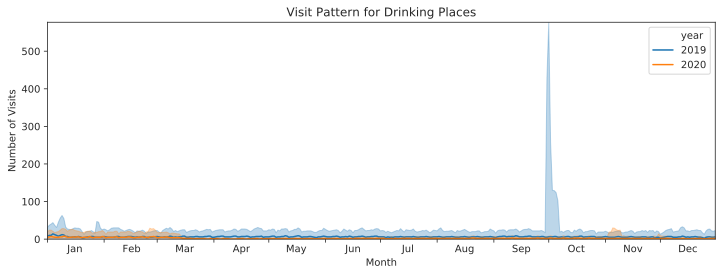

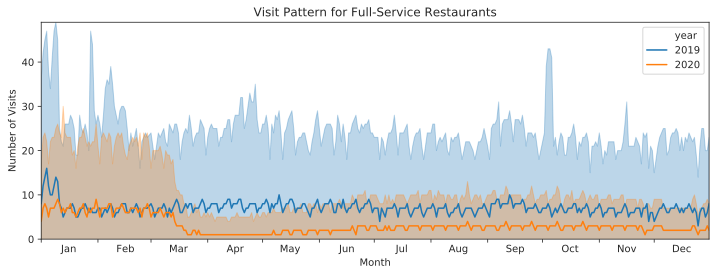

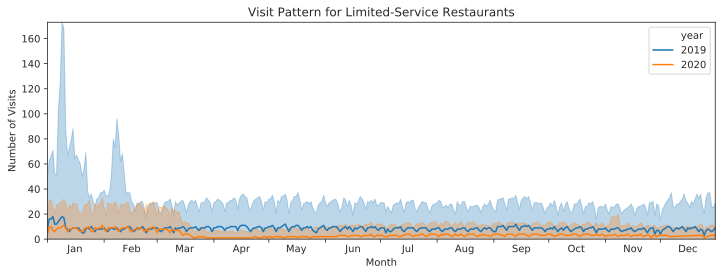

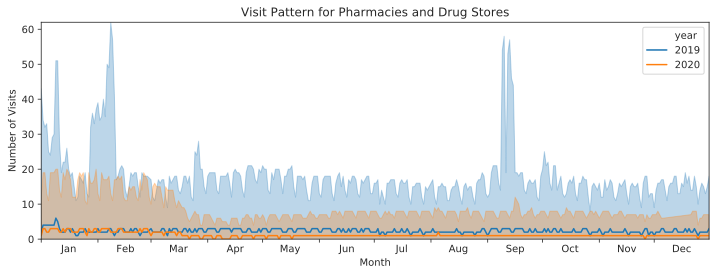

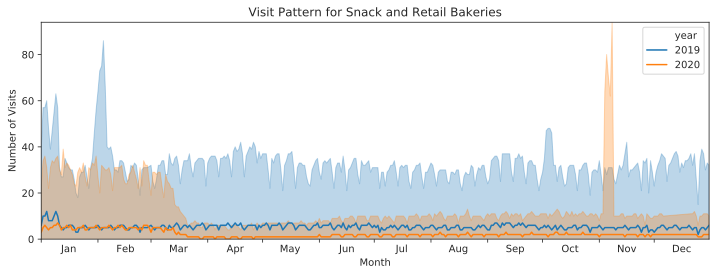

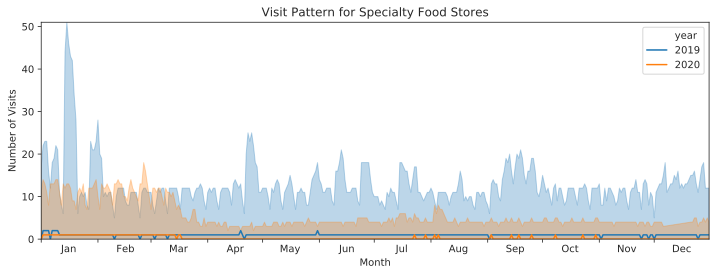

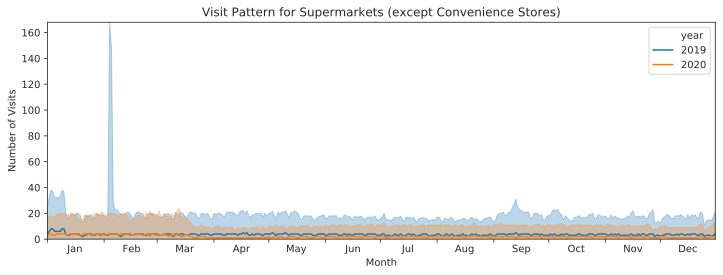

In [ ]:
for fn in ('big_box_grocers.csv',
           'convenience_stores.csv',
           'drinking_places.csv',
           'full_service_restaurants.csv',
           'limited_service_restaurants.csv',
           'pharmacies_and_drug_stores.csv',
           'snack_and_bakeries.csv',
           'specialty_food_stores.csv',
           'supermarkets_except_convenience_stores.csv'):
    title = fn[:-4].replace('_', ' ').title()
    linePlot(fn, title=f'Visit Pattern for {title}')